In [6]:
import pandas as pd
import numpy as np
from collections import deque
import json
import requests

In [7]:
from useful_functions import crypto_raw_to_pandas, parse_all_book_updates, binary_price
from OrderBook import OrderBook

### Pulling In crypto data

In [8]:
crypto_data_filename = "btc_and_price_data/chainlink_crypto_prices_2025-10-30.jsonl"
df = crypto_raw_to_pandas(crypto_data_filename)

In [9]:
df.head()

,connection_id,timestamp,topic,type,full_accuracy_value,symbol,unix_timestamp,value
0,TO_BKeC3LPECFBw=,2025-10-30 00:04:51.081,crypto_prices_chainlink,update,3902042700000000000000,eth/usd,1761782690000,3902.042700
1,TO_BKeC3LPECFBw=,2025-10-30 00:04:51.089,crypto_prices_chainlink,update,109992585115583980000000,btc/usd,1761782690000,109992.585116
2,TO_BKeC3LPECFBw=,2025-10-30 00:04:51.084,crypto_prices_chainlink,update,2545512701164238700,xrp/usd,1761782690000,2.545513
3,TO_BKeC3LPECFBw=,2025-10-30 00:04:51.086,crypto_prices_chainlink,update,193526622095049330000,sol/usd,1761782690000,193.526622
4,TO_BKeC3LPECFBw=,2025-10-30 00:04:51.639,crypto_prices_chainlink,update,109994709366500000000000,btc/usd,1761782691000,109994.709366


In [10]:
btc_df = df[df['symbol'] == "btc/usd"].sort_values(by="unix_timestamp").reset_index(drop=True)

In [11]:
btc_df.head()

,connection_id,timestamp,topic,type,full_accuracy_value,symbol,unix_timestamp,value
0,TO_BKeC3LPECFBw=,2025-10-30 00:04:51.089,crypto_prices_chainlink,update,109992585115583980000000,btc/usd,1761782690000,109992.585116
1,TO_BKeC3LPECFBw=,2025-10-30 00:04:51.639,crypto_prices_chainlink,update,109994709366500000000000,btc/usd,1761782691000,109994.709366
2,TO_BKeC3LPECFBw=,2025-10-30 00:04:52.922,crypto_prices_chainlink,update,109994244301159970000000,btc/usd,1761782692000,109994.244301
3,TO_BKeC3LPECFBw=,2025-10-30 00:04:54.049,crypto_prices_chainlink,update,109995046216000000000000,btc/usd,1761782693000,109995.046216
4,TO_BKeC3LPECFBw=,2025-10-30 00:04:54.635,crypto_prices_chainlink,update,109995246274500000000000,btc/usd,1761782694000,109995.246274


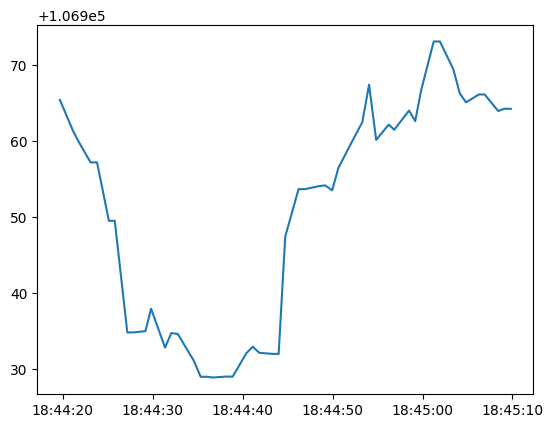

In [12]:
import matplotlib.pyplot as plt
start = 63178
a = 765 * 4
w = 50
index = start-a
plt.plot(btc_df['timestamp'].iloc[start-a-w:start-a+w], btc_df['value'].iloc[start-a-w:start-a+w])

### IMPORTANT NOTE ABOUT STRIKE PRICE, IT IS ALWAYS THE PRICE THAT ARRIVES > 0.685s after the cutoff period

- 10/30 at 3:45 PM ET -> 63167	TRkfRcdTLPECEjw=	2025-10-30 19:45:01.084	106712029701995930000000	btc/usd	1761853500000	106712.029702
    -   True price = $106,712.03
    -   NOTE -> there was a price sent after time but it wasn't the price: 2025-10-30 19:45:00.354  106706018356014190000000	btc/usd	1761853499000	106706.018356
- 10/30 at 3:30 PM ET -> 62271	TRkfRcdTLPECEjw=	2025-10-30 19:30:00.800	update	106977710624929315000000	btc/usd	1761852600000	106977.710625
    -   True price = $106,977.71
- 10/30 at 3:15 PM ET -> 61390	TRkfRcdTLPECEjw=	2025-10-30 19:15:01.367	106875697703027500000000	btc/usd	1761851700000	106875.697703
    -   True price = $106,875.70
- 10/30 at 3:00 PM ET -> 60512	TRkfRcdTLPECEjw=	2025-10-30 19:00:00.899	106820959922286540000000	btc/usd	1761850800000	106820.959922
    -   True price = $106,820.96
- 10/30 at 2:45 PM ET -> 
    -   True price = $106,973.11


In [13]:
import datetime as dt
def get_strike_init_data(data):
    first_ts = data.iloc[0]['timestamp']
    last_ts = data.iloc[-1]['timestamp']
    current_ts = dt.datetime(first_ts.year, first_ts.month, first_ts.day, first_ts.hour, first_ts.minute//15*15, 0, 0)
    
    possible_strike_rows = []
    buffer = 2
    while current_ts < last_ts:
        possible_strike_rows.append(data[(data['timestamp'] >= current_ts) & (data['timestamp'] <= (current_ts+dt.timedelta(seconds=3, milliseconds=0)))])
        # if current_ts == dt.datetime(2025, 10, 30, 9, 30, 0, 0):
        #     print(data[(data['timestamp'] >= current_ts-dt.timedelta(seconds=1)) & (data['timestamp'] <= (current_ts+dt.timedelta(seconds=2, milliseconds=0)))])
        current_ts += dt.timedelta(minutes=15)
    
    return pd.concat(possible_strike_rows)


In [14]:
strikes = get_strike_init_data(btc_df)

In [15]:
data = btc_df
current_ts = dt.datetime(2025, 10, 30, 9, 30, 0, 0)

In [16]:
data[(data['timestamp'] >= current_ts) & (data['timestamp'] <= (current_ts+dt.timedelta(seconds=2, milliseconds=500)))]

,connection_id,timestamp,topic,type,full_accuracy_value,symbol,unix_timestamp,value


In [17]:
# for _, row in data.iterrows():
#     print(row)

In [18]:
for _, row in strikes.iterrows():
    print(row['timestamp'], row['value'])

2025-10-30 00:15:00.386000 110162.8639665
2025-10-30 00:15:00.989000 110160.9871644047
2025-10-30 00:15:01.840000 110160.9871644047
2025-10-30 00:30:00.103000 110388.3482514329
2025-10-30 00:30:00.939000 110390.9333796622
2025-10-30 00:30:01.792000 110394.7311950606
2025-10-30 00:30:02.887000 110376.1688711866
2025-10-30 00:45:00.980000 110451.8235371067
2025-10-30 00:45:02.185000 110451.1106598826
2025-10-30 00:45:02.777000 110450.8876404633
2025-10-30 01:00:01.075000 110561.0117390768
2025-10-30 01:00:01.710000 110561.0358695384
2025-10-30 01:00:02.995000 110563.0515483759
2025-10-30 01:15:01.257000 110512.0406820323
2025-10-30 01:15:01.929000 110510.9228377613
2025-10-30 01:30:00.034000 110387.2652291621
2025-10-30 01:30:00.688000 110387.4496469187
2025-10-30 01:30:01.896000 110385.4799972634
2025-10-30 01:45:01.057000 110615.6047620486
2025-10-30 01:45:01.666000 110616.204637686
2025-10-30 02:00:00.262000 110458.4209085
2025-10-30 02:00:00.802000 110458.6161585
2025-10-30 02:00:02.

In [19]:
ts = btc_df.iloc[0]['timestamp']
rounded_ts = dt.datetime(ts.year, ts.month, ts.day, ts.hour, ts.minute//15*15, 0, 0)

In [20]:
ts, rounded_ts

(Timestamp('2025-10-30 00:04:51.089000'),
 datetime.datetime(2025, 10, 30, 0, 0))

### Pulling Market Book Update Data

In [21]:
# Get market details from slug
url = "https://gamma-api.polymarket.com/events"
slug = "btc-updown-15m-1761786000"
response = requests.get(url, params={"slug": slug})

# yes_token_id, no_token_id = response.json()[0]['markets'][0]['clobTokenIds']
yes_token_id, no_token_id = json.loads(response.json()[0]['markets'][0]['clobTokenIds'])

In [22]:
yes_token_id

'83183308674131023197302415258788997759161749822734524473545155235350145282641'

In [23]:
messages = []

with open (f"btc_and_price_data/{slug}.jsonl") as f:
    # Thu Oct 30 2025 01:00:00 GMT+0000
    for line in f:
        line_data = json.loads(line)
        messages.append(line_data)

order_book_updates = parse_all_book_updates(messages)

In [38]:
# update to appropriate typings
for update in order_book_updates:
    update['price'] = float(update['price'])
    update['size'] = float(update['size'])
    update['timestamp'] = int(update['timestamp'])

#### NOTE -> parse all book updates is broken, as the book message is for yes regardless of which token you're getting, but the update messages are appropriately mirrored. Because of this, we use the yes book for our backtests

In [39]:
yes_book_updates = [update for update in order_book_updates if update['asset_id'] == yes_token_id]
no_book_updates = [update for update in order_book_updates if update['asset_id'] == no_token_id]

In [40]:
len(yes_book_updates), len(no_book_updates), len(yes_book_updates) + len(no_book_updates), len(order_book_updates)

(70462, 70460, 140922, 140922)

### Taking Vol and Order Book Data to price model and backtest

In [41]:
yes_book_updates == sorted(yes_book_updates, key=lambda x: (x['timestamp'], x['price'])) # our yes book updates list is already in order

False

In [42]:
crypto_price_queue = deque(zip(btc_df['unix_timestamp'], btc_df['value']))
market_update_queue = deque(yes_book_updates)

In [43]:
unix_start_time = 1761786000 * 1000
unix_end_time = unix_start_time + 900*1000 #+ 20 * 1000 # buffer

In [44]:
class Vol:
    def __init__(self, effective_memory):
        self.effective_memory = effective_memory
        self.var_lambda = 1-1/effective_memory
        self.secs_in_year = 3.154e+7
        self.vol = 0
        self.prev_price = np.nan
    
    def compute_vol(self, return_val):
        return np.sqrt(return_val**2)

    def update_vol_from_price(self, price):
        if np.isnan(self.prev_price) or price <= 0:
            return_val = 0.0
        else:
            return_val = np.log(price/self.prev_price)
        vol_measurement = self.compute_vol(return_val) * np.sqrt(self.secs_in_year) # make it annualized assuming secondly data TODO -> this may be bad if delta t isn't 1 second
        self.vol = (1-self.var_lambda) * vol_measurement + self.var_lambda * self.vol
        self.prev_price = price


In [51]:
## BACKTESTING

time = unix_start_time - 300*1000 # # minus 5 minutes for crypto vol warm up, +1 time = +1 milliseconds
point_685_seconds = 685 # 685 ms

data_over_time = []

crypto_price = np.nan
vol = np.nan
market_price = np.nan
strike_price = np.nan
order_book = OrderBook()
vol_tracker = Vol(effective_memory=300) # 5 minutes of effective memory?


while time <= unix_end_time:
    print(time)

    while crypto_price_queue and crypto_price_queue[0][0] <= time:
        crypto_timestamp, new_crypto_price = crypto_price_queue.popleft()
        vol_tracker.update_vol_from_price(new_crypto_price)

        if np.isnan(strike_price) and time >= unix_start_time + point_685_seconds:
            # get the strike price of the market
            strike_price = new_crypto_price
    
        crypto_price = new_crypto_price

    tte = float((unix_end_time - time) / 3.154e+10) # milliseconds * (year / milliseconds)
    
    # now that we have a new price, get the option value
    theo_price = binary_price(S=crypto_price, X = strike_price, T=tte, vol = vol_tracker.vol, r = 0.0431) # r = sofr

    while market_update_queue and market_update_queue[0]['timestamp'] <= time:
        update = market_update_queue.popleft()
        order_book.update(side=update['side'], price=update['price'], size=update['size'], timestamp = update['timestamp'])

    # compute metrics and store
    data_point = {
        "timestamp": time,
        "crypto_price": crypto_price,
        "vol": vol_tracker.vol,
        "market_spread": order_book.spread,
        "best_bid": order_book.best_bid,
        "best_ask": order_book.best_ask,
        "theo_price": theo_price,
        "mid_price": order_book.mid,
        "lwm_price": order_book.lwm
    }
    data_over_time.append(data_point)
    time += 1

# figure out what the crypto final value was
next_start_time = unix_start_time + 900*1000 # add 900 seconds
resolve_price = np.nan
while crypto_price_queue and np.isnan(resolve_price):
    crypto_timestamp, new_crypto_price = crypto_price_queue.popleft()

    if time >= next_start_time + point_685_seconds:
        # get the strike price of the market
        resolve_price = new_crypto_price

# determine the final results of the market (later)